# Transit Fitting

Welcome to the transit fitting tutorial of `chromatic_fitting`! In this tutorial we will go through how to create a simulated transit using the handy `chromatic` package and then fit it using the transit model (`TransitModel`) in `chromatic_fitting`.

In [1]:
# import chromatic_fitting of course!
from chromatic_fitting import *

# import any prior distributions we want to use for our parameters - I've chosen Normal and Uniform from pymc3
# and QuadLimbDark and ImpactParameter from exoplanet
from pymc3 import Normal, Uniform
from exoplanet import QuadLimbDark, ImpactParameter

# import astropy table just for this tutorial (pandas dataframes don't show up nicely on the docs pages!)
from astropy.table import Table
import matplotlib.pyplot as plt 

plt.matplotlib.style.use('default')

Running chromatic_fitting v0.11.0!

This program is running on:
Python v3.9.12 (main, Jun  1 2022, 06:34:44) 
[Clang 12.0.0 ]
numpy v1.22.1
chromatic v0.4.5
pymc3 v3.11.5
pymc3_ext v0.1.1
exoplanet v0.5.2


## Create Synthetic Rainbow + Transit

To create our simulated data set we will use `SimulatedRainbow()` from within `chromatic`. This creates only basic data with time and wavelength axes. Then we want to inject some noise (to make it realistic) and then inject a transit (the whole point of this tutorial). By default `chromatic` will inject a planet with Rp/R* of 0.1, but we want to make things a little more realistic so we will make the radius ratio vary linearly with wavelength.

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

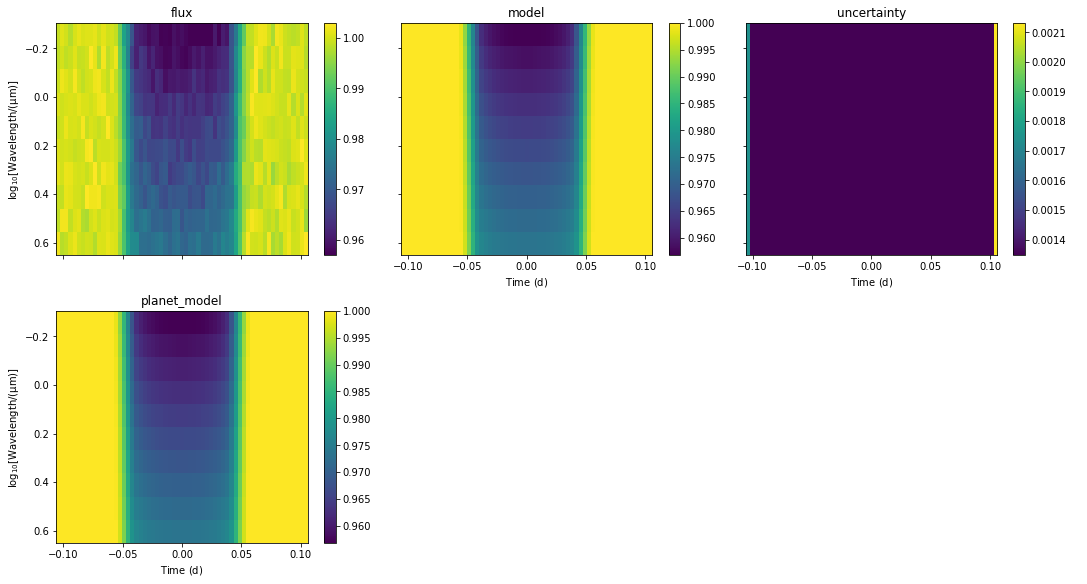

In [2]:
# create transit rainbow:
r = SimulatedRainbow(dt=1 * u.minute, R=50).inject_noise(signal_to_noise=100)

# add transit (with depth varying with wavelength):
r = r.inject_transit(
        planet_radius=np.linspace(0.2, 0.15, r.nwave),
        P=1.0,
        t0=0.0,
        baseline=1.0
    )

# bin into 10 wavelength bins:
nw = 10
rb = r.bin(nwavelengths=int(r.nwave/nw), dt=5 * u.minute)

# show the simulated dataset
rb.imshow_quantities();

In [3]:
rb

<Simulated🌈(10w, 61t)>

## Define a PyMC3 Transit Model

Now onto `chromatic_fitting`. First we need to create a transit model.

In [4]:
# create transit model:
t = TransitModel()

Then we will want to decide how our parameters will vary. We can see the parameters that we will need to provide to the model. **Warning:** if we dont set any of these parameters then they will take on default values.

In [5]:
t.required_parameters

['stellar_radius',
 'stellar_mass',
 'radius_ratio',
 'period',
 'epoch',
 'baseline',
 'impact_parameter',
 'limb_darkening']

In [6]:
t.defaults

{'stellar_radius': 1.0,
 'stellar_mass': 1.0,
 'radius_ratio': 1.0,
 'period': 1.0,
 'epoch': 0.0,
 'baseline': 1.0,
 'impact_parameter': 0.5,
 'eccentricity': 0.0,
 'omega': 0,
 'limb_darkening': [0.2, 0.2]}

Usually when we're fitting a transit we'll have some idea about the transit parameters (from previous literature or just looking at the lightcurves by eye), so it's a good idea to give good initial estimates to help our sampling converge nicely. Here we're defining the prior distributions for each parameter. There are four options for parameters in `chromatic_fitting`: `Fixed`, `WavelikeFixed`, `Fitted`, and `WavelikeFitted`. `Fixed` is one value fixed across all wavelengths, `WavelikeFixed` are fixed values that can vary between wavelengths. `Fitted` determines a prior distribution (e.g. `Uniform`, `Normal`, `TruncatedNormal`) that we will use to fit one value for the parameter across all wavelengths. Similarly, `WavelikeFitted` is a prior distribution that we will use to fit for a different value for every wavelength. 

In [7]:
# add our parameters:
t.setup_parameters(
                  period=1.0, # a fixed value!
                   epoch=Fitted(Uniform,lower=-0.05,upper=0.05), # one fitted value across all wavelengths
                   stellar_radius = Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   stellar_mass =Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   radius_ratio=WavelikeFitted(Normal, mu=0.17, sigma=0.05), # a different value fitted for every wavelength!
                   impact_parameter=Fitted(ImpactParameter,ror=0.15,testval=0.44),
                   limb_darkening=WavelikeFitted(Uniform,testval=[0.2,0.2], shape=2),
                    baseline = WavelikeFitted(Normal, mu=1.0, sigma=0.05), 
                )

# print a summary of all params:
t.summarize_parameters()

transit_stellar_radius =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='transit_stellar_radius') 🧮>

transit_stellar_mass =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='transit_stellar_mass') 🧮>

transit_radius_ratio =
  <🧮 WavelikeFitted Normal(mu=0.17, sigma=0.05, name='transit_radius_ratio') for each wavelength 🧮>

transit_period =
  <🧮 Fixed | 1.0 🧮>

transit_epoch =
  <🧮 Fitted Uniform(lower=-0.05, upper=0.05, name='transit_epoch') 🧮>

transit_baseline =
  <🧮 WavelikeFitted Normal(mu=1.0, sigma=0.05, name='transit_baseline') for each wavelength 🧮>

transit_impact_parameter =
  <🧮 Fitted ImpactParameter(ror=0.15, testval=0.44, name='transit_impact_parameter') 🧮>

transit_eccentricity =
  <🧮 Fixed | 0.0 🧮>

transit_omega =
  <🧮 Fixed | 0 🧮>

transit_limb_darkening =
  <🧮 WavelikeFitted Uniform(testval=[0.2, 0.2], shape=2, name='transit_limb_darkening') for each wavelength 🧮>



## Attach the Rainbow Object and Set-up the Model

The next step is to attach the actual data to the model and setup the lightcurves!

In [8]:
# attach the Rainbow object to the model:
t.attach_data(rb)

# this is the last point where we can change the optimization method:
t.choose_optimization_method("separate")

# setup the lightcurves for the transit model & 
# t.setup_lightcurves()
# relate the "actual" data to the model (using a Normal likelihood function)
t.setup_likelihood()

.setup_lightcurves() has not been run yet, running now...


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:166: UserWarning: transit in the parameter name: transit_stellar_radius. Please avoid having the model name in the parameter name as it can get confusing!
  warnings.warn(


.setup_lightcurves() has not been run yet, running now...
.setup_lightcurves() has not been run yet, running now...
.setup_lightcurves() has not been run yet, running now...
.setup_lightcurves() has not been run yet, running now...
.setup_lightcurves() has not been run yet, running now...
.setup_lightcurves() has not been run yet, running now...
.setup_lightcurves() has not been run yet, running now...
.setup_lightcurves() has not been run yet, running now...
.setup_lightcurves() has not been run yet, running now...


If we look at our `PyMC3` model we can see that it has a lot of parameters to optimize! If we've chosen the separate wavelength fitting method (`.choose_optimization_method("separate")`) then `._pymc3_model` will return a list of PyMC3 models (one for each wavelength).

In [9]:
# print(t._pymc3_model)
t

<chromatic models (10 separate wavelengths) "transit" 🌈>

We've got our transit parameters that are wavelength-independant in this case (`epoch, impact_parameter, stellar_radius, stellar_mass, a_R*, limb_darkening`) and the wavelength-dependant parameters we've defined to be `radius_ratio` and `baseline` only. The `data` parameter just represents the fit of the data to the model at each wavelength (which we've defined to be a Normal distribution). If we've set `store_models = True` at the `.setup_lightcurves()` stage then we will also see a bunch of models!

Now we can plot a couple of priors (samples from our prior distribution) - do they look OK?

In [11]:
# t.plot_priors()

Plotting the priors can be reassuring for two reasons: (1) we're not giving priors that are vastly off from the true values, and (2) we're not over-constraining our model by giving it the exact solution and priors that are too tight.

Another check is does this planetary system actually transit given our parameters?

In [12]:
t.plot_orbit()
# t.orbit

AttributeError: 'LightcurveModels' object has no attribute 'plot_orbit'

Looks good! And a final check of what the actual lightcurves look like:

The summarize step has not been run yet. To include the 'best-fit' model please run {self}.sample() and {self}.summarize() before calling this step!


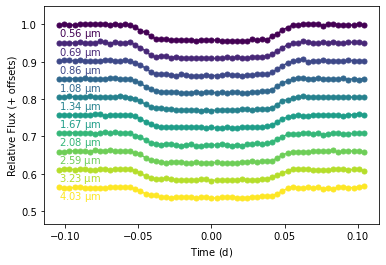

In [13]:
t.plot_lightcurves()

## PyMC3 sampling

Now we can run the NUTS sampling for our light curves (first by optimizing our initial values)

optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


message: Desired error not necessarily achieved due to precision loss.
logp: -2770.647895806509 -> 313.526674262712
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:501: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(
optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


message: Desired error not necessarily achieved due to precision loss.
logp: -2366.390068915988 -> 304.042249843847


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:501: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(
optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


message: Desired error not necessarily achieved due to precision loss.
logp: -1976.967893107701 -> 311.9587051562191


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:501: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(
optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


message: Desired error not necessarily achieved due to precision loss.
logp: -1513.2401505979467 -> 321.24611868215294


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:501: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(
optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


message: Desired error not necessarily achieved due to precision loss.
logp: -1208.8534633729375 -> 313.53901500434483


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:501: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(
optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


message: Optimization terminated successfully.
logp: -1048.983167636449 -> 315.04306599835587


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:501: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(
optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


message: Desired error not necessarily achieved due to precision loss.
logp: -801.8024017882209 -> -521.749029157649
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:501: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(
optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


message: Optimization terminated successfully.
logp: -728.3940357420083 -> 307.0900266374301


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:501: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(
optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


message: Desired error not necessarily achieved due to precision loss.
logp: -555.0917102922488 -> 311.21515059984705


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:501: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(
optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


message: Desired error not necessarily achieved due to precision loss.
logp: -502.0543669265495 -> 306.22097463207245


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:501: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(


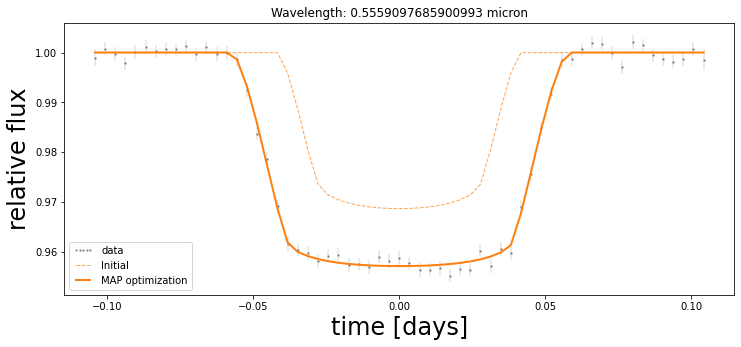

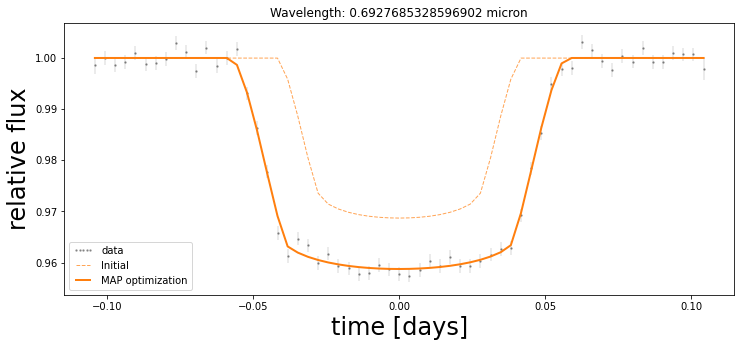

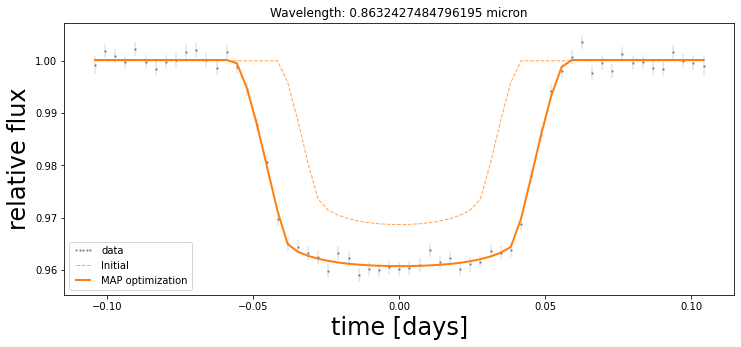

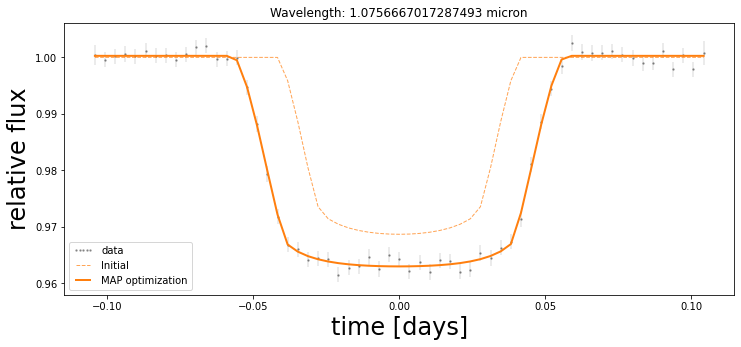

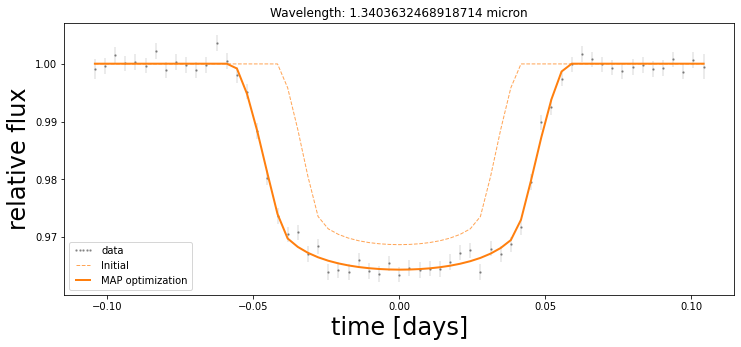

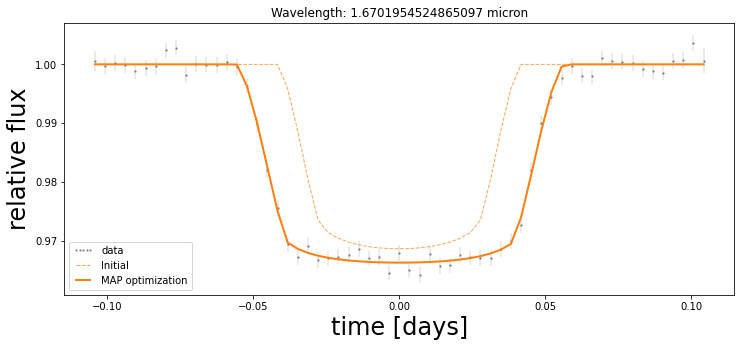

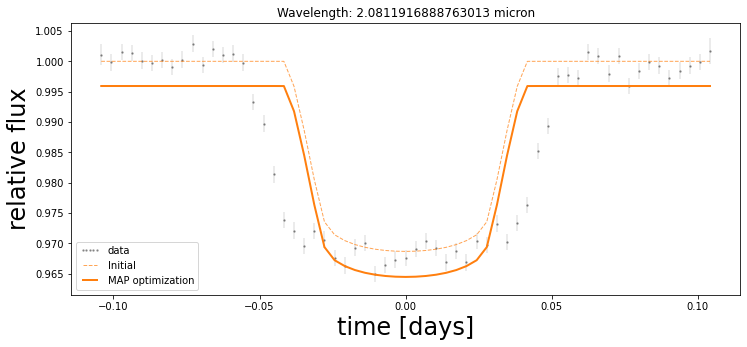

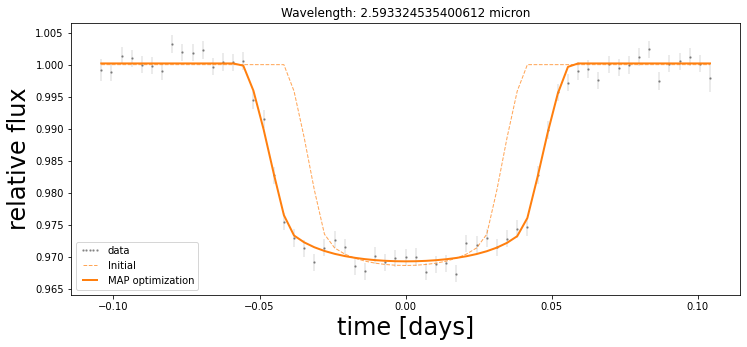

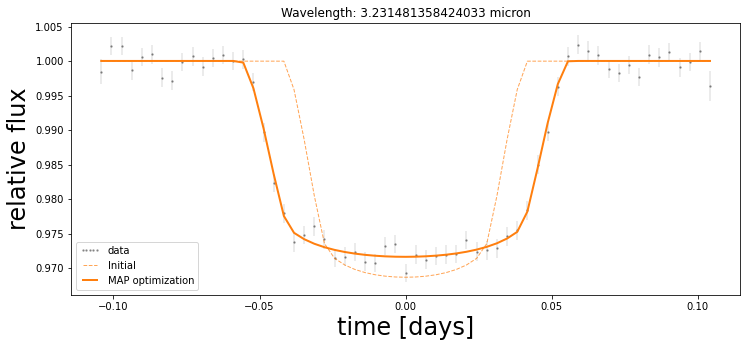

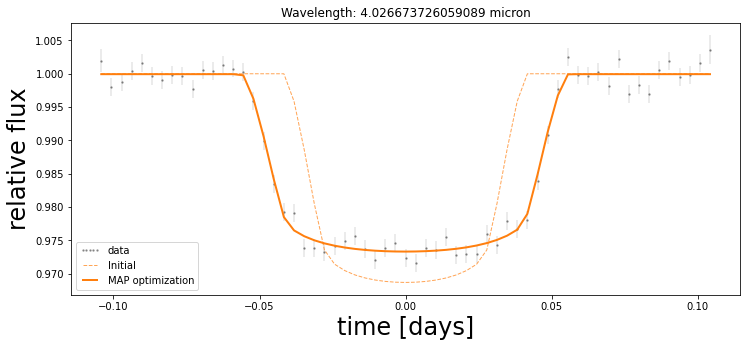

In [15]:
# optimize for initial values!
opt = t.optimize(plot=True)

In [16]:
# put those initial values into the sampling and define the number of tuning and draw steps, 
# as well as the number of chains. NOTE: if you do separate wavelength fitting then the number of steps 
# is per wavelengths, not divided between the wavelengths!
t.sample(use_optimized_start_point=True, tune=2000, draws=2000, chains=4, cores=4) #start=opt, 

Sampling model using the <function sample at 0x17c372820> method
Using MAP-optimized start point...


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 75 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameteri

                                  mean        sd   hdi_16%   hdi_84%  \
transit_radius_ratio[0]       0.199712  0.001770  0.198167  0.201580   
transit_baseline[0]           1.000030  0.000260  0.999758  1.000283   
transit_epoch[0]              0.000203  0.000192  0.000028  0.000405   
transit_impact_parameter[0]   0.122080  0.071218  0.036520  0.196454   
transit_stellar_radius[0]     1.181844  0.012520  1.176601  1.199972   
transit_stellar_mass[0]       0.843185  0.028461  0.805136  0.860380   
transit_limb_darkening[0, 0]  0.098294  0.062894  0.002327  0.128803   
transit_limb_darkening[0, 1]  0.227636  0.140993  0.010319  0.298062   
transit_a_R*[0]               3.363700  0.033962  3.330430  3.399851   
transit_planet_radius[0]      0.236025  0.003093  0.232938  0.239298   

                              mcse_mean   mcse_sd     ess_bulk     ess_tail  \
transit_radius_ratio[0]        0.000044  0.000031  1578.672778  1287.525968   
transit_baseline[0]            0.000006  0.000004

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 57 seconds.
There were 88 divergences after tuning. Increase `target_accept` or reparameteri

                                  mean        sd   hdi_16%   hdi_84%  \
transit_radius_ratio[0]       0.195015  0.001489  0.193508  0.196441   
transit_baseline[0]           1.000024  0.000264  0.999777  1.000295   
transit_epoch[0]             -0.000134  0.000196 -0.000338  0.000050   
transit_impact_parameter[0]   0.073159  0.050488  0.000166  0.092929   
transit_stellar_radius[0]     1.177356  0.014101  1.169879  1.199913   
transit_stellar_mass[0]       0.850034  0.031346  0.802588  0.867177   
transit_limb_darkening[0, 0]  0.175527  0.067549  0.117254  0.254285   
transit_limb_darkening[0, 1]  0.128838  0.110625  0.000074  0.154199   
transit_a_R*[0]               3.385496  0.026684  3.363456  3.414367   
transit_planet_radius[0]      0.229600  0.003133  0.226624  0.233177   

                              mcse_mean   mcse_sd     ess_bulk     ess_tail  \
transit_radius_ratio[0]        0.000036  0.000025  1738.596709  2497.842244   
transit_baseline[0]            0.000009  0.000006

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 62 seconds.
There were 162 divergences after tuning. Increase `target_accept` or reparameter

                                  mean        sd   hdi_16%   hdi_84%  \
transit_radius_ratio[0]       0.191472  0.001671  0.190043  0.193330   
transit_baseline[0]           1.000162  0.000256  0.999896  1.000404   
transit_epoch[0]              0.000348  0.000212  0.000131  0.000558   
transit_impact_parameter[0]   0.101690  0.070153  0.000011  0.129345   
transit_stellar_radius[0]     1.179779  0.013669  1.174000  1.199954   
transit_stellar_mass[0]       0.849808  0.032012  0.801122  0.865416   
transit_limb_darkening[0, 0]  0.114454  0.066584  0.021148  0.160303   
transit_limb_darkening[0, 1]  0.193018  0.134058  0.000766  0.244783   
transit_a_R*[0]               3.378270  0.034320  3.348844  3.418835   
transit_planet_radius[0]      0.225892  0.003114  0.222576  0.229195   

                              mcse_mean   mcse_sd     ess_bulk     ess_tail  \
transit_radius_ratio[0]        0.000070  0.000050   511.775017   494.453034   
transit_baseline[0]            0.000007  0.000005

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 75 seconds.
There were 99 divergences after tuning. Increase `target_accept` or reparameteri

                                  mean        sd   hdi_16%   hdi_84%  \
transit_radius_ratio[0]       0.185326  0.001807  0.183774  0.187288   
transit_baseline[0]           1.000267  0.000271  1.000022  1.000545   
transit_epoch[0]             -0.000094  0.000231 -0.000313  0.000136   
transit_impact_parameter[0]   0.101835  0.067490  0.000954  0.132962   
transit_stellar_radius[0]     1.179110  0.014280  1.172991  1.199998   
transit_stellar_mass[0]       0.845284  0.030940  0.800799  0.859024   
transit_limb_darkening[0, 0]  0.100682  0.066956  0.005930  0.133209   
transit_limb_darkening[0, 1]  0.273802  0.158661  0.077827  0.419891   
transit_a_R*[0]               3.374260  0.035737  3.340630  3.411860   
transit_planet_radius[0]      0.218516  0.003181  0.215235  0.221821   

                              mcse_mean   mcse_sd     ess_bulk     ess_tail  \
transit_radius_ratio[0]        0.000042  0.000029  1825.581322  1751.212130   
transit_baseline[0]            0.000010  0.000007

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 56 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameteri

                                  mean        sd   hdi_16%   hdi_84%  \
transit_radius_ratio[0]       0.177122  0.001740  0.175394  0.178887   
transit_baseline[0]           1.000054  0.000255  0.999821  1.000331   
transit_epoch[0]              0.000281  0.000244  0.000025  0.000512   
transit_impact_parameter[0]   0.081410  0.056185  0.000014  0.105592   
transit_stellar_radius[0]     1.188077  0.009097  1.184956  1.199943   
transit_stellar_mass[0]       0.824983  0.019207  0.800006  0.831480   
transit_limb_darkening[0, 0]  0.238829  0.098211  0.152649  0.357100   
transit_limb_darkening[0, 1]  0.256381  0.181142  0.002647  0.331355   
transit_a_R*[0]               3.321992  0.028962  3.290527  3.350358   
transit_planet_radius[0]      0.210431  0.002287  0.208274  0.212831   

                              mcse_mean   mcse_sd     ess_bulk     ess_tail  \
transit_radius_ratio[0]        0.000032  0.000023  2955.684211  2838.674620   
transit_baseline[0]            0.000004  0.000003

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 58 seconds.
There were 493 divergences after tuning. Increase `target_accept` or reparameter

                                  mean        sd   hdi_16%   hdi_84%  \
transit_radius_ratio[0]       0.177005  0.001842  0.175137  0.178620   
transit_baseline[0]           1.000020  0.000246  0.999784  1.000258   
transit_epoch[0]              0.000287  0.000233  0.000059  0.000500   
transit_impact_parameter[0]   0.150821  0.095591  0.000859  0.199264   
transit_stellar_radius[0]     1.181715  0.015083  1.175831  1.199979   
transit_stellar_mass[0]       0.847598  0.034149  0.802235  0.860121   
transit_limb_darkening[0, 0]  0.091648  0.068550  0.000213  0.120165   
transit_limb_darkening[0, 1]  0.234904  0.144177  0.046060  0.338487   
transit_a_R*[0]               3.369987  0.052566  3.334523  3.441385   
transit_planet_radius[0]      0.209171  0.003531  0.205872  0.212848   

                              mcse_mean   mcse_sd    ess_bulk     ess_tail  \
transit_radius_ratio[0]        0.000137  0.000097  196.080467    87.873486   
transit_baseline[0]            0.000010  0.000007  

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 58 seconds.
There were 54 divergences after tuning. Increase `target_accept` or reparameteri

                                  mean        sd   hdi_16%   hdi_84%  \
transit_radius_ratio[0]       0.168320  0.001882  0.166737  0.170445   
transit_baseline[0]           0.999834  0.000257  0.999598  1.000101   
transit_epoch[0]             -0.000660  0.000258 -0.000918 -0.000410   
transit_impact_parameter[0]   0.100472  0.066818  0.001641  0.130894   
transit_stellar_radius[0]     1.183668  0.012005  1.179379  1.199964   
transit_stellar_mass[0]       0.834002  0.025702  0.800010  0.843033   
transit_limb_darkening[0, 0]  0.217600  0.097561  0.132133  0.334826   
transit_limb_darkening[0, 1]  0.264099  0.189493  0.000218  0.341380   
transit_a_R*[0]               3.346401  0.036677  3.306741  3.384393   
transit_planet_radius[0]      0.199230  0.002612  0.196481  0.201831   

                              mcse_mean   mcse_sd     ess_bulk     ess_tail  \
transit_radius_ratio[0]        0.000037  0.000026  2499.823804  2356.439042   
transit_baseline[0]            0.000005  0.000003

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 56 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameteri

                                  mean        sd   hdi_16%   hdi_84%  \
transit_radius_ratio[0]       0.166173  0.001743  0.164678  0.168214   
transit_baseline[0]           1.000202  0.000258  0.999945  1.000463   
transit_epoch[0]              0.000133  0.000265 -0.000128  0.000398   
transit_impact_parameter[0]   0.088852  0.060244  0.001673  0.116930   
transit_stellar_radius[0]     1.185895  0.010294  1.181941  1.199714   
transit_stellar_mass[0]       0.830084  0.022445  0.800041  0.837716   
transit_limb_darkening[0, 0]  0.211600  0.091289  0.124714  0.312598   
transit_limb_darkening[0, 1]  0.214696  0.160275  0.000070  0.268082   
transit_a_R*[0]               3.334905  0.032070  3.304491  3.370058   
transit_planet_radius[0]      0.197060  0.002382  0.194695  0.199511   

                              mcse_mean   mcse_sd     ess_bulk     ess_tail  \
transit_radius_ratio[0]        0.000030  0.000022  3219.823337  3106.323183   
transit_baseline[0]            0.000004  0.000003

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 57 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameteri

                                  mean        sd   hdi_16%   hdi_84%  \
transit_radius_ratio[0]       0.159728  0.001785  0.158039  0.161624   
transit_baseline[0]           1.000040  0.000254  0.999754  1.000260   
transit_epoch[0]             -0.000212  0.000282 -0.000517  0.000048   
transit_impact_parameter[0]   0.099751  0.066670  0.000005  0.130052   
transit_stellar_radius[0]     1.184749  0.010988  1.180397  1.199996   
transit_stellar_mass[0]       0.833594  0.024315  0.800031  0.842645   
transit_limb_darkening[0, 0]  0.196296  0.092996  0.112630  0.307233   
transit_limb_darkening[0, 1]  0.218488  0.162598  0.001720  0.276734   
transit_a_R*[0]               3.342797  0.033875  3.309241  3.378619   
transit_planet_radius[0]      0.189234  0.002478  0.186497  0.191534   

                              mcse_mean   mcse_sd     ess_bulk     ess_tail  \
transit_radius_ratio[0]        0.000034  0.000024  2728.319629  2995.347531   
transit_baseline[0]            0.000005  0.000003

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 57 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameteri

                                  mean        sd   hdi_16%   hdi_84%  \
transit_radius_ratio[0]       0.154715  0.001819  0.152923  0.156522   
transit_baseline[0]           0.999948  0.000253  0.999691  1.000185   
transit_epoch[0]             -0.000182  0.000285 -0.000468  0.000104   
transit_impact_parameter[0]   0.087627  0.060194  0.000105  0.112147   
transit_stellar_radius[0]     1.185701  0.010437  1.181900  1.199990   
transit_stellar_mass[0]       0.830996  0.022812  0.800008  0.838842   
transit_limb_darkening[0, 0]  0.176683  0.095274  0.072965  0.277830   
transit_limb_darkening[0, 1]  0.252744  0.173780  0.001409  0.329057   
transit_a_R*[0]               3.336663  0.032278  3.300957  3.367660   
transit_planet_radius[0]      0.183442  0.002384  0.180914  0.185676   

                              mcse_mean   mcse_sd     ess_bulk     ess_tail  \
transit_radius_ratio[0]        0.000034  0.000024  2917.285689  2817.226688   
transit_baseline[0]            0.000005  0.000003

At this stage the sampler may print out some warnings that we don't have enough tuning steps! Also be aware this step can be quite slow depending on how many parameters we're trying to fit at once (which may increase with the number of wavelengths). We can then see the results of our sampling by running `.summarize()`:

In [17]:
t.summary

,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
transit_radius_ratio[0],0.199712,0.001770,0.198167,0.201580,0.000044,0.000031,1578.672778,1287.525968,1.004019
transit_baseline[0],1.000030,0.000260,0.999758,1.000283,0.000006,0.000004,2146.920956,3032.595363,1.000787
transit_epoch[0],0.000203,0.000192,0.000028,0.000405,0.000004,0.000003,2501.128939,1852.174131,1.000503
transit_impact_parameter[0],0.122080,0.071218,0.036520,0.196454,0.002205,0.001746,919.809918,662.933229,1.005484
transit_stellar_radius[0],1.181844,0.012520,1.176601,1.199972,0.000338,0.000240,1100.758409,757.313844,1.005564
...,...,...,...,...,...,...,...,...,...
transit_stellar_mass[9],0.830996,0.022812,0.800008,0.838842,0.000491,0.000347,1638.489851,1305.001561,1.002603
"transit_limb_darkening[9, 9]",0.176683,0.095274,0.072965,0.277830,0.002301,0.001627,1567.960600,1108.721108,1.001573
"transit_limb_darkening[9, 1]",0.252744,0.173780,0.001409,0.329057,0.004319,0.003054,1340.496920,1040.788136,1.001941
transit_a_R*[9],3.336663,0.032278,3.300957,3.367660,0.000663,0.000469,2240.970002,1669.602575,1.001170


An important parameter to look out for here to check whether your samplings have converged is [`r_hat`](https://arviz-devs.github.io/arviz/api/generated/arviz.rhat.html#arviz.rhat). This [rank normalized R-hat diagnostic](https://arxiv.org/abs/1903.08008) tests for lack of convergence by comparing the variance between multiple chains to the variance within each chain. If convergence has been achieved, the between-chain and within-chain variances should be identicalm therefore, the closer it is to 1 the better the chance that your sampling successfully converged. If you're interested in the sampling see the [`PyMC3 docs`](https://docs.pymc.io/en/v3/index.html) for much more detail!

In [ ]:
np.all(t.summary['r_hat'].values < 1.1) # check the convergence is good!

We might also want to see a couple of posterior samples as a "quick-look" check! **But beware** if you've chosen the "separate" optimization method then it will plot the posteriors for every wavelength!):

In [ ]:
# t.plot_posteriors()

But what are the results?? We can easily see the results using the handy `.get_results()` function:

In [ ]:
t.parameters['transit_a_R*'] = []
results = t.get_results(uncertainty='sd')#['hdi_16%','hdi_84%'])

# results is a pandas dataframe, however, it doesn't show up properly on Git docs so I'll convert it to an
# astropy table
from astropy.table import Table
Table.from_pandas(results)

We can also make a transmission spectrum table using `.make_transmission_spectrum_table() `

In [ ]:
TransitModel.make_transmission_spectrum_table(t)

In [29]:
TransitModel.make_transmission_spectrum_table(t)

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/transit.py:375: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_table[f"{self.name}_radius_ratio_neg_error"] = (


,wavelength,transit_radius_ratio,transit_radius_ratio_neg_error,transit_radius_ratio_pos_error
w0,0.5559097685900993 micron,0.199712,0.001545,0.001868
w1,0.6927685328596902 micron,0.195015,0.001507,0.001426
w2,0.8632427484796195 micron,0.191472,0.001429,0.001858
w3,1.0756667017287493 micron,0.185326,0.001552,0.001962
w4,1.3403632468918714 micron,0.177122,0.001728,0.001765
w5,1.6701954524865097 micron,0.177005,0.001867,0.001616
w6,2.0811916888763013 micron,0.16832,0.001583,0.002125
w7,2.593324535400612 micron,0.166173,0.001495,0.002041
w8,3.231481358424033 micron,0.159728,0.001689,0.001896
w9,4.026673726059089 micron,0.154715,0.001793,0.001806


In [20]:
transmission_spectrum = t.make_transmission_spectrum_table(uncertainty=['hdi_16%','hdi_84%'])

Table.from_pandas(transmission_spectrum)

AttributeError: 'LightcurveModels' object has no attribute 'make_transmission_spectrum_table'

We can also create (or call if you set `store_models=True`) the final best-fit models using the `.get_models()` function. This can take a minute if generating the models from parameters for lots of wavelengths.

In [28]:
models = t.get_model()
models.keys()

dict_keys(['w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9'])

As the `.get_model()` process can take time to generate the models, we store the models for use later...

In [29]:
t._fit_models.keys()

dict_keys(['w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9'])

## Visualizing Results

We have several different methods (mostly wrappers to `chromatic` functions) to plot the modelled results. I'll demonstrate several of them below:

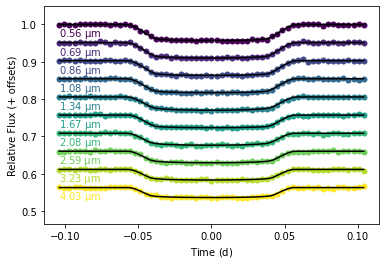

In [21]:
t.plot_lightcurves()

## Check Residuals

No model attached to data. Running `add_model_to_rainbow` now. You can access this data later using [self].data_with_model


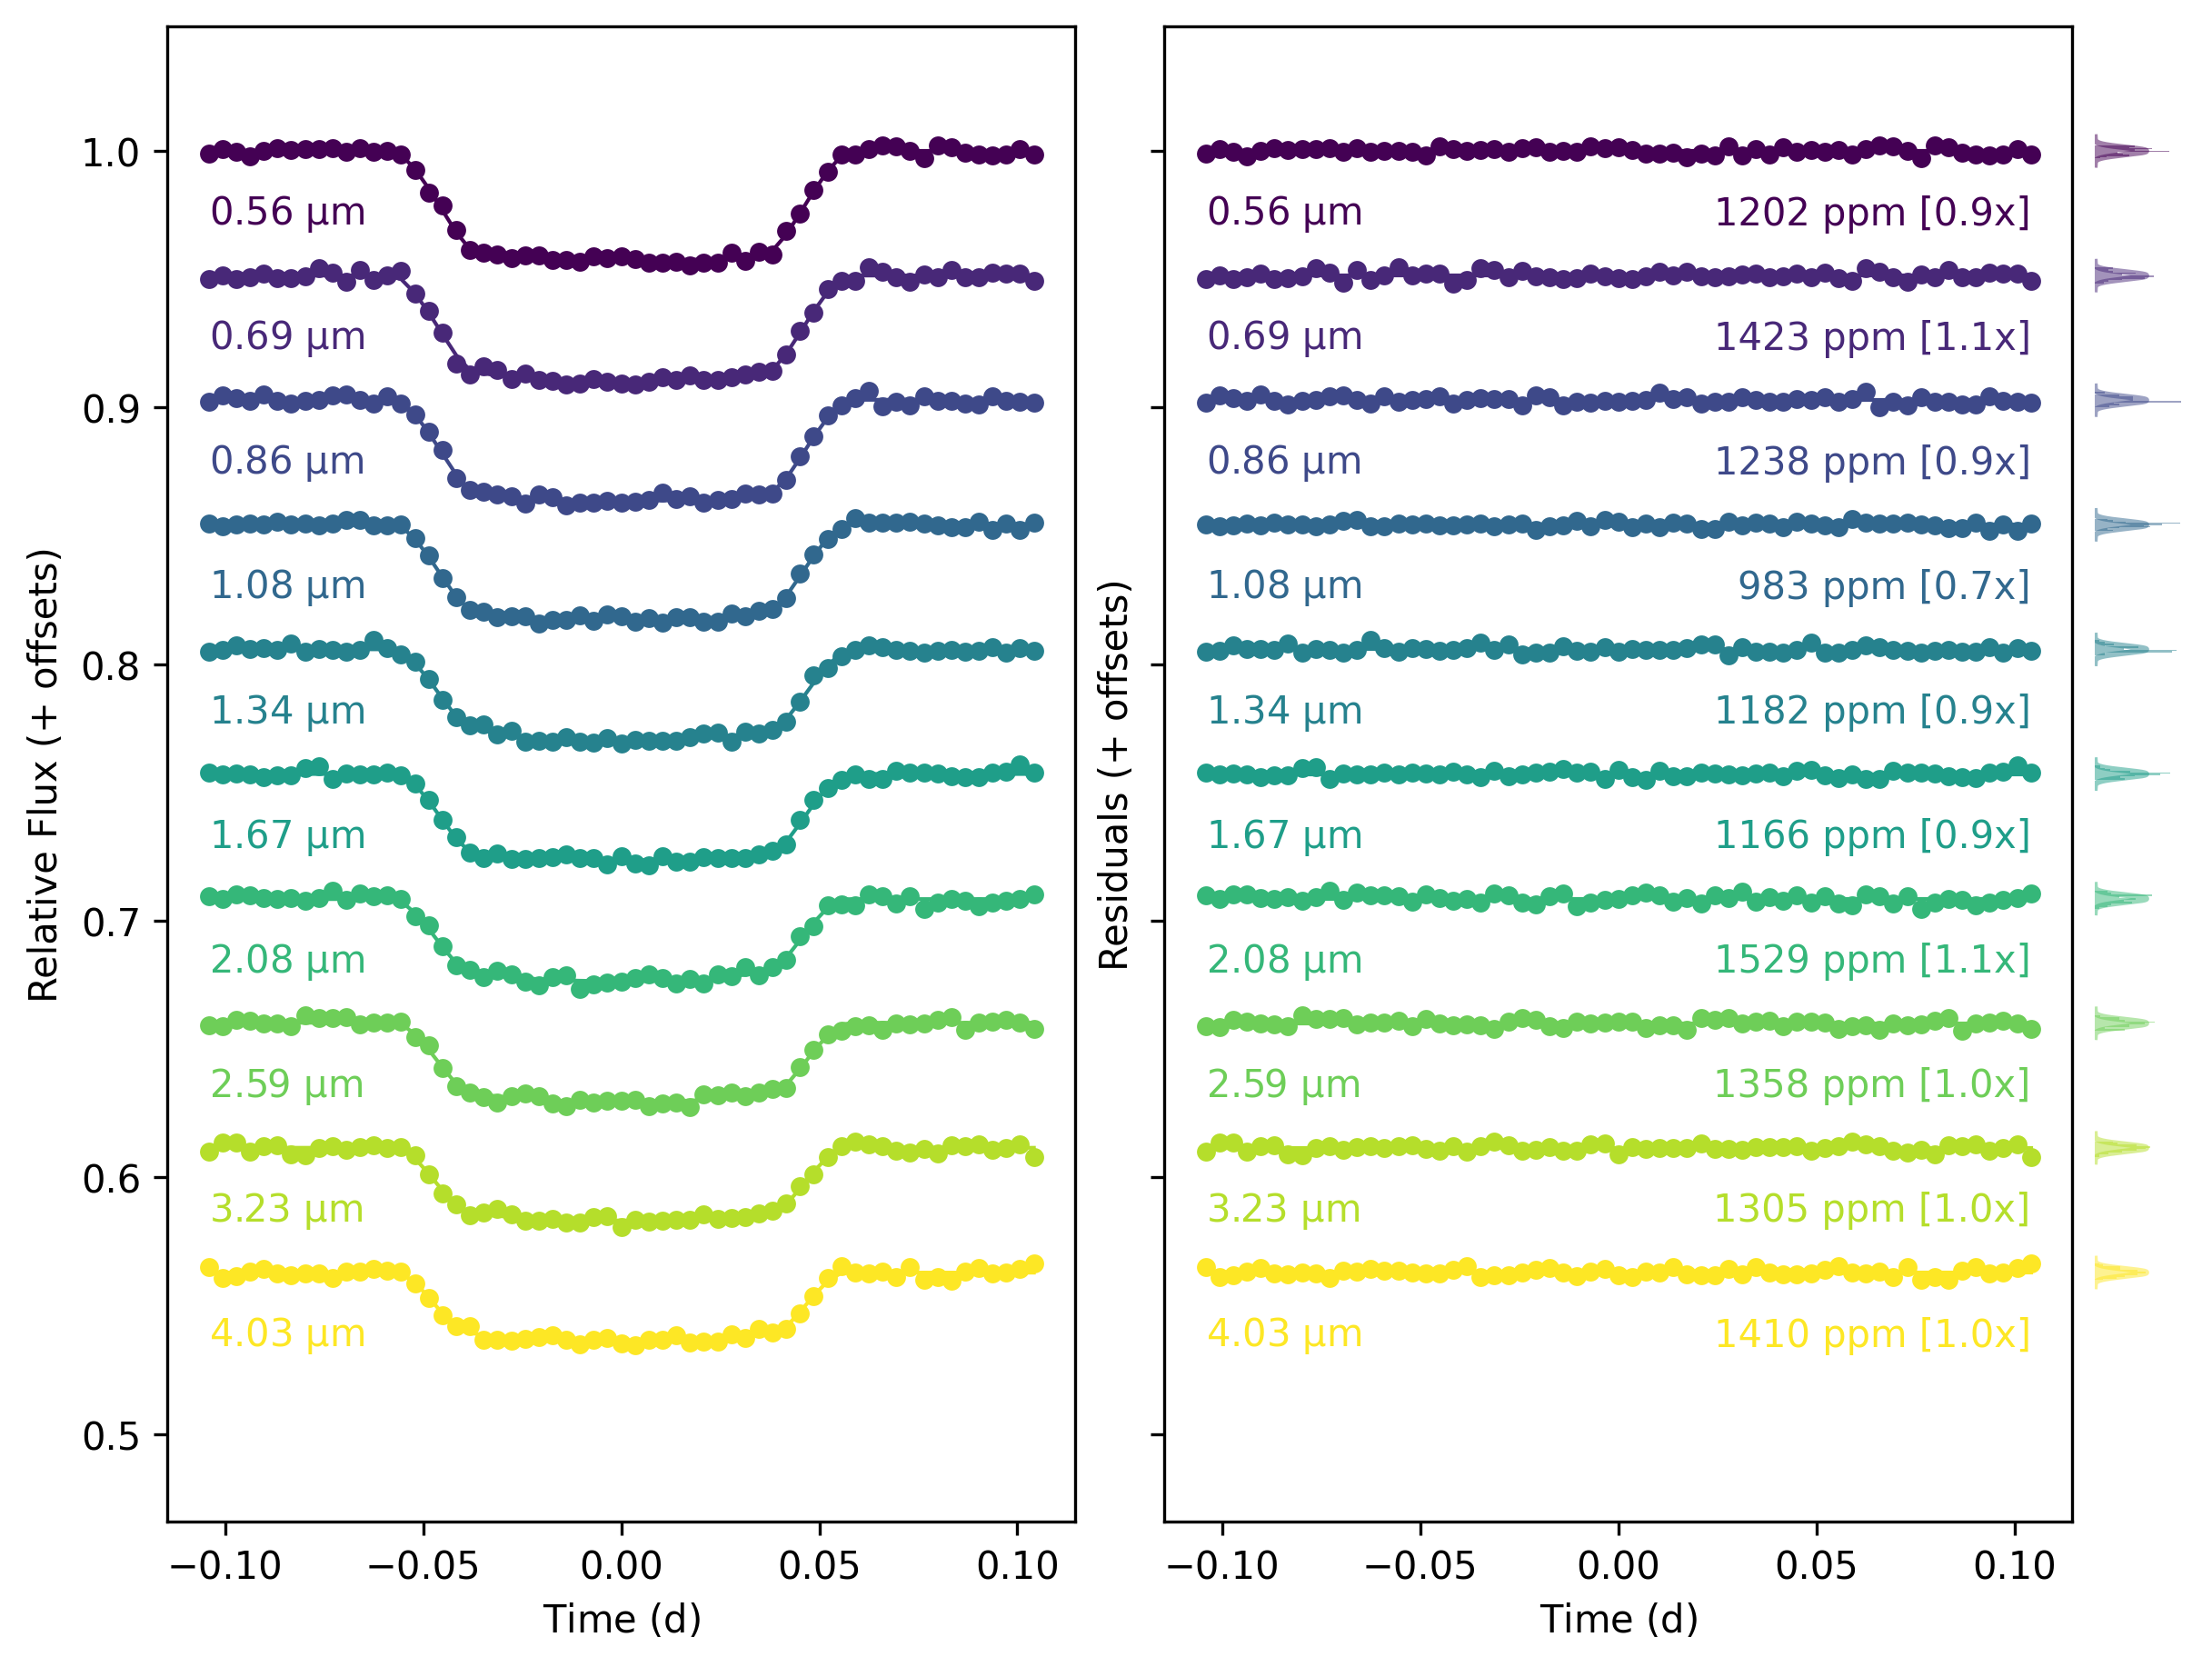

In [22]:
t.plot_with_model_and_residuals()

🌈🤖 'systematics_model' doesn't exist and will be skipped.



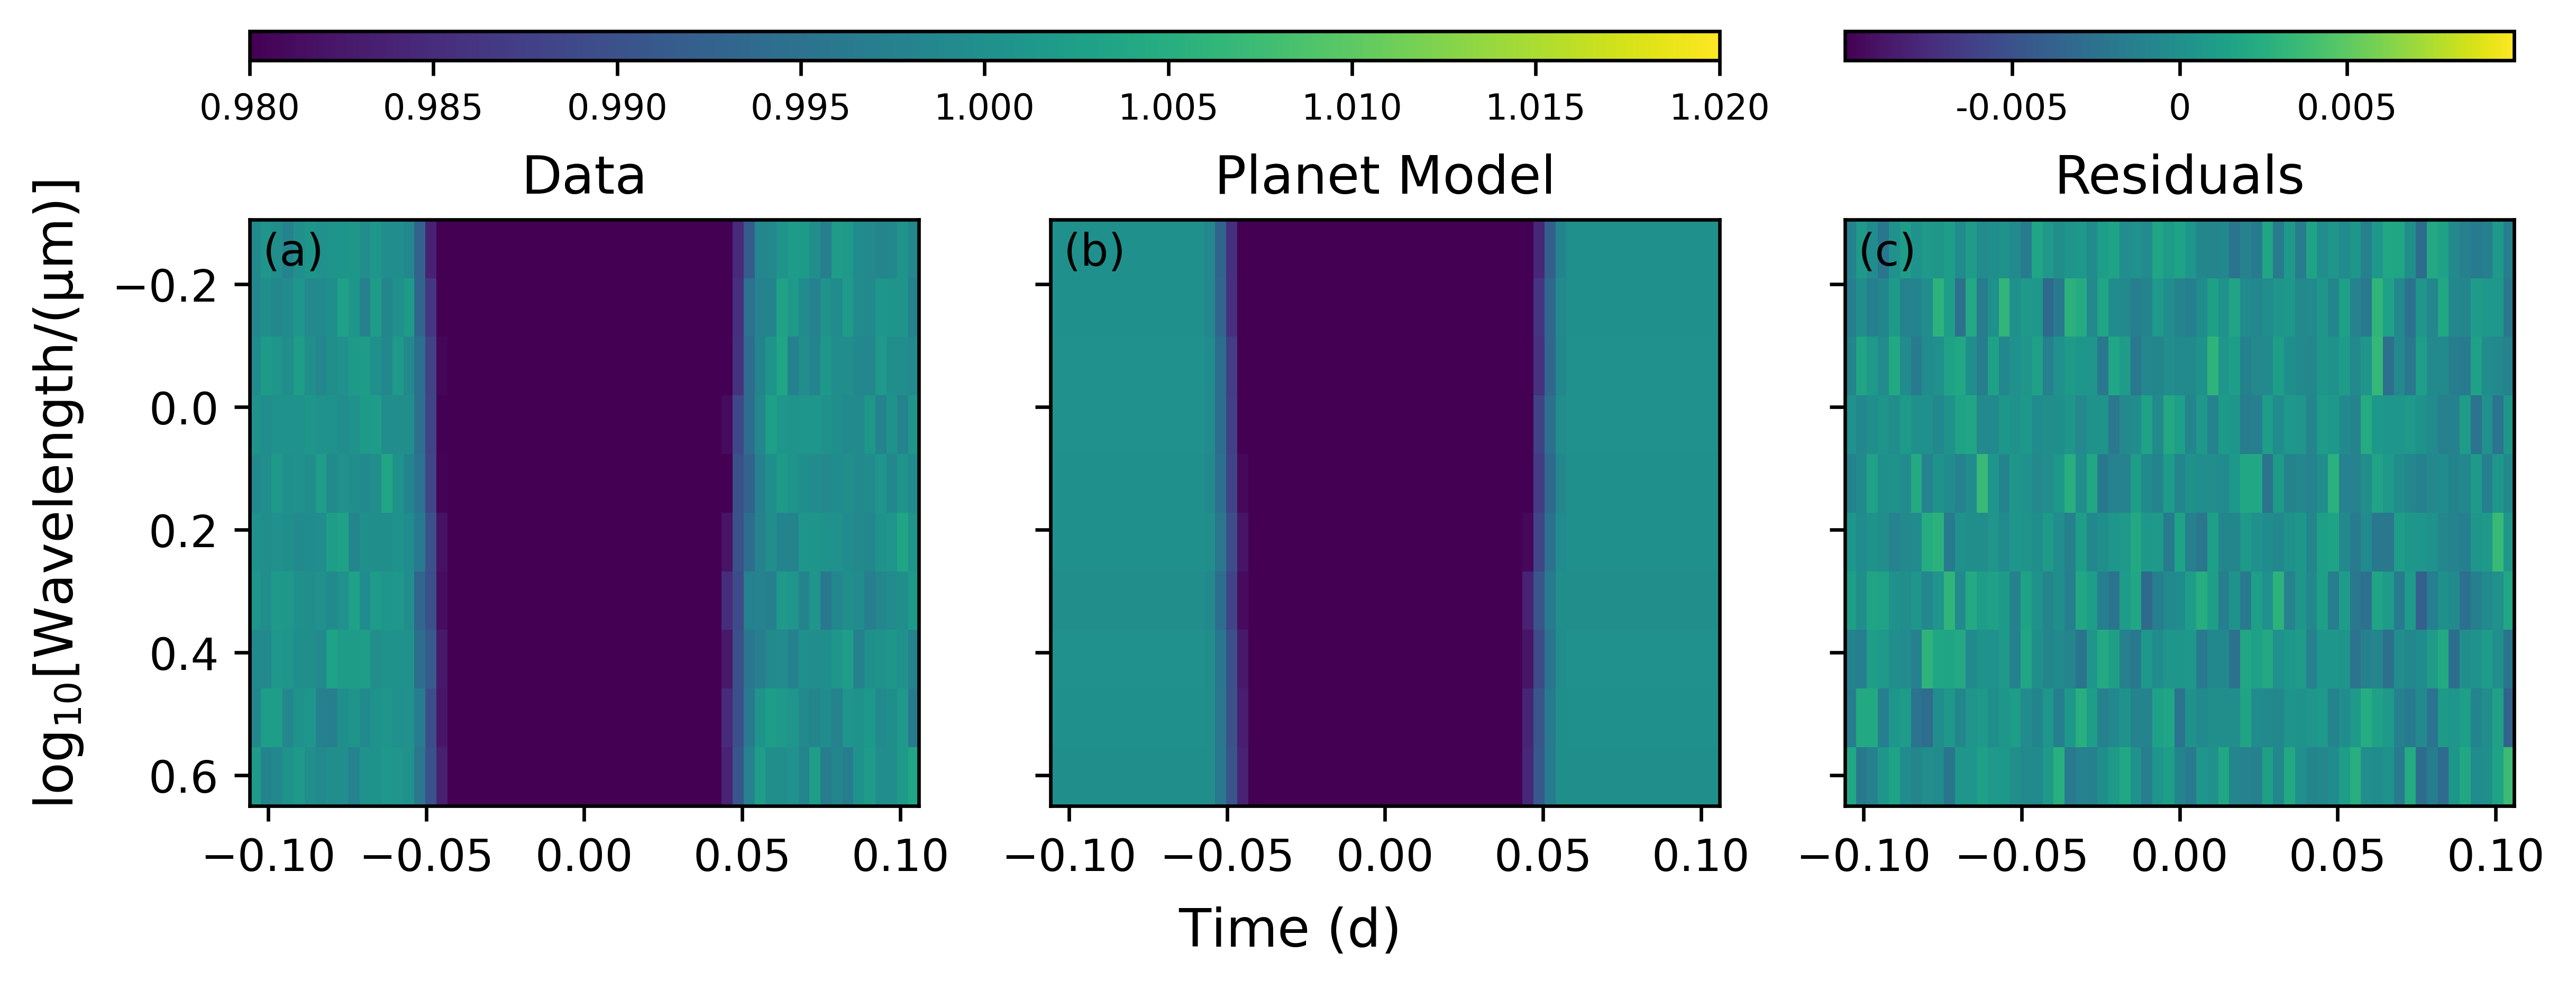

In [23]:
t.imshow_with_models(vspan_residuals=0.01)

## Plot the Transmission Spectrum

We can also plot the transmission spectrum (and we know what the true values are). Here's what we know about the injected transit:

In [33]:
rb.metadata['injected_transit_parameters']

{'rp': array([0.2       , 0.19956522, 0.19913043, 0.19869565, 0.19826087,
        0.19782609, 0.1973913 , 0.19695652, 0.19652174, 0.19608696,
        0.19565217, 0.19521739, 0.19478261, 0.19434783, 0.19391304,
        0.19347826, 0.19304348, 0.1926087 , 0.19217391, 0.19173913,
        0.19130435, 0.19086957, 0.19043478, 0.19      , 0.18956522,
        0.18913043, 0.18869565, 0.18826087, 0.18782609, 0.1873913 ,
        0.18695652, 0.18652174, 0.18608696, 0.18565217, 0.18521739,
        0.18478261, 0.18434783, 0.18391304, 0.18347826, 0.18304348,
        0.1826087 , 0.18217391, 0.18173913, 0.18130435, 0.18086957,
        0.18043478, 0.18      , 0.17956522, 0.17913043, 0.17869565,
        0.17826087, 0.17782609, 0.1773913 , 0.17695652, 0.17652174,
        0.17608696, 0.17565217, 0.17521739, 0.17478261, 0.17434783,
        0.17391304, 0.17347826, 0.17304348, 0.1726087 , 0.17217391,
        0.17173913, 0.17130435, 0.17086957, 0.17043478, 0.17      ,
        0.16956522, 0.16913043, 0.16869565

Plot the transmission spectrum (and in this case we can compare to the original model):

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/transit.py:410: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_table[f"{self.name}_radius_ratio_neg_error"] = (


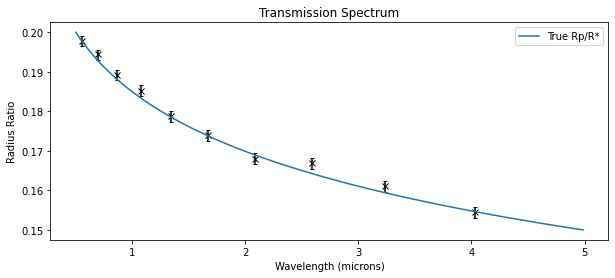

In [34]:
t.plot_transmission_spectrum(uncertainty=['hdi_16%','hdi_84%'])
plt.plot(r.wavelength, rb.metadata['injected_transit_parameters']['rp'], label="True Rp/R*")

plt.legend();

We can also run some diagnostic checks to see the quality of our fit! You might want to check the chi-squared or reduced chi-squared statistic:


For Entire Simultaneous Fit:
Fitted Parameters:
 transit_radius_ratio[0], transit_radius_ratio[1], transit_radius_ratio[2], transit_radius_ratio[3], transit_radius_ratio[4], transit_radius_ratio[5], transit_radius_ratio[6], transit_radius_ratio[7], transit_radius_ratio[8], transit_radius_ratio[9], transit_baseline[0], transit_baseline[1], transit_baseline[2], transit_baseline[3], transit_baseline[4], transit_baseline[5], transit_baseline[6], transit_baseline[7], transit_baseline[8], transit_baseline[9], transit_epoch[0], transit_impact_parameter[0], transit_stellar_radius[0], transit_stellar_mass[0], transit_a_R*[0], transit_limb_darkening[0, 0], transit_limb_darkening[0, 1], transit_limb_darkening[1, 0], transit_limb_darkening[1, 1], transit_limb_darkening[2, 0], transit_limb_darkening[2, 1], transit_limb_darkening[3, 0], transit_limb_darkening[3, 1], transit_limb_darkening[4, 0], transit_limb_darkening[4, 1], transit_limb_darkening[5, 0], transit_limb_darkening[5, 1], transit_limb_d

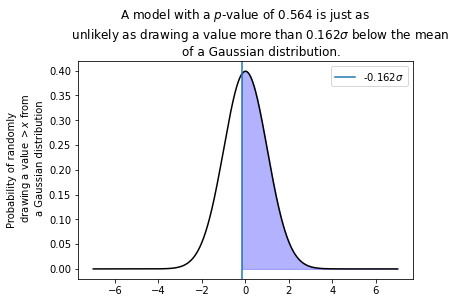

In [36]:
t.chi_squared(plot=True)

Or we can inspect the residual with several different plotting methods:

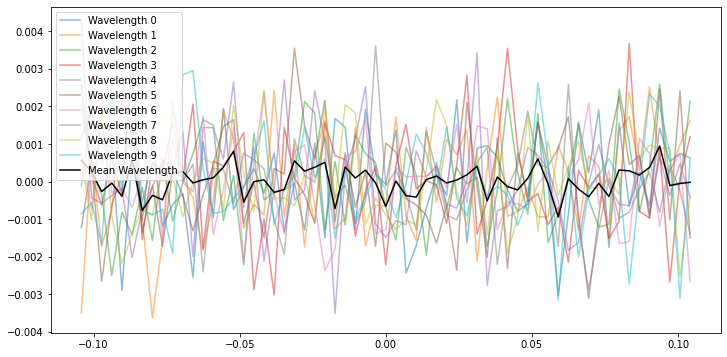

In [37]:
t.plot_residuals()

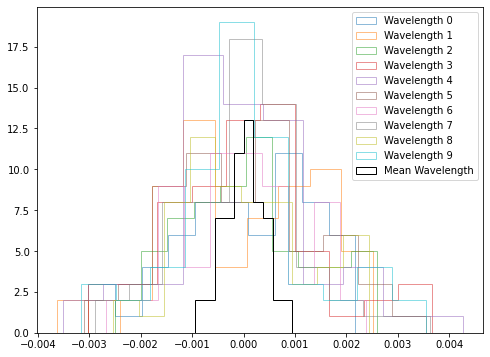

In [38]:
t.plot_residuals_histogram()

For the Wavelength-Averaged Residuals...


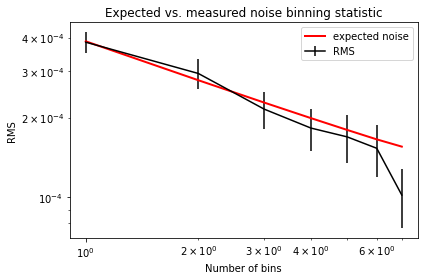

Calculated white noise: 0.00037476 

        Calculated red noise: 9.1097e-05 

        Calculated beta: 1.2932

For wavelength 0


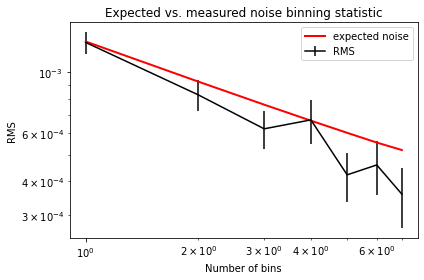

Calculated white noise: 0.001273 

        Calculated red noise: 0.00018721 

        Calculated beta: 1.12

For wavelength 1


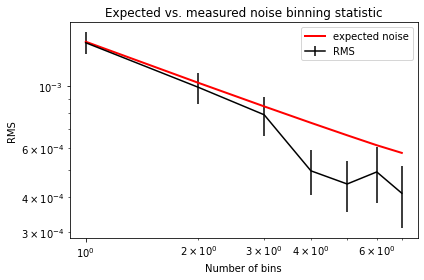

Calculated white noise: 0.0014157 

        Calculated red noise: 0.00019146 

        Calculated beta: 1.1027

For wavelength 2


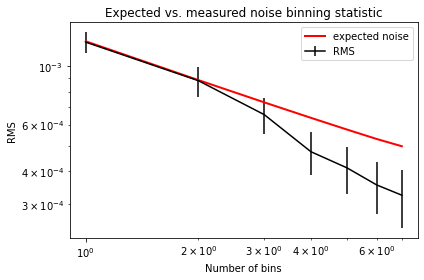

Calculated white noise: 0.00123 

        Calculated red noise: 7.8938e-05 

        Calculated beta: 1.0243

For wavelength 3


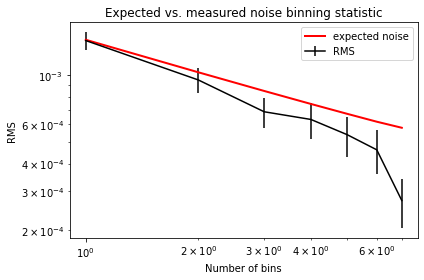

Calculated white noise: 0.001433 

        Calculated red noise: 9.5031e-05 

        Calculated beta: 1.0259

For wavelength 4


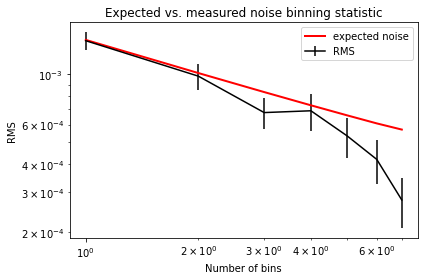

Calculated white noise: 0.0014099 

        Calculated red noise: 5.6282e-05 

        Calculated beta: 1.0095

For wavelength 5


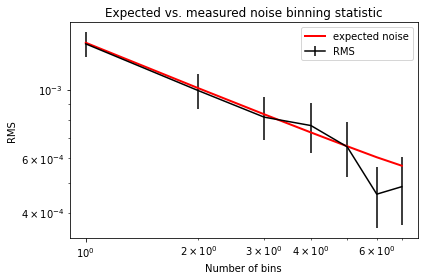

Calculated white noise: 0.0013612 

        Calculated red noise: 0.00035985 

        Calculated beta: 1.3371

For wavelength 6


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/utils.py:75: RuntimeWarning: invalid value encountered in sqrt
  base_noise = np.sqrt(final_noise**2 - root_mean_square[0] ** 2 / nbins[midbin])


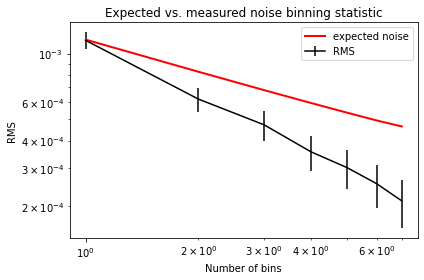

Calculated white noise: 0 

        Calculated red noise: 0 

        Calculated beta: 1

For wavelength 7


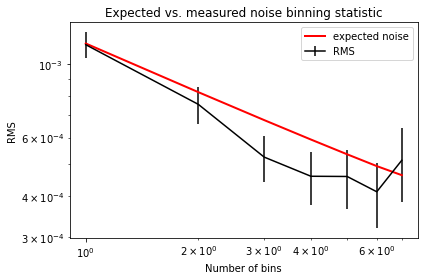

Calculated white noise: 0.0010976 

        Calculated red noise: 0.0003345 

        Calculated beta: 1.4235

For wavelength 8


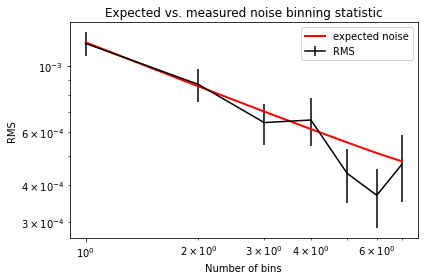

Calculated white noise: 0.001161 

        Calculated red noise: 0.0002614 

        Calculated beta: 1.2574

For wavelength 9


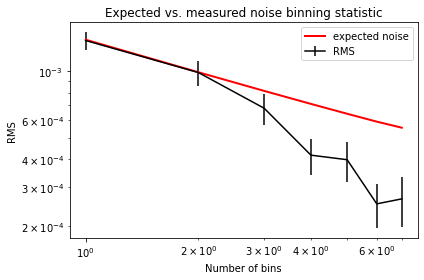

Calculated white noise: 0 

        Calculated red noise: 0 

        Calculated beta: 1


In [39]:
t.residual_noise_calculator()

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/diagnostics/statistics.py:71: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogx(1 / freq, power)


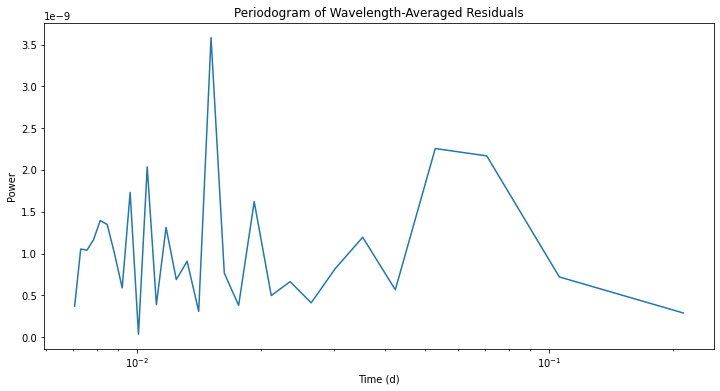

In [40]:
t.plot_residuals_periodogram()